# Using DLPy to build U-Net model

## 1. Business problem

Image segmentation is to understand an image at pixel level. Specifically, semantic segmentation attempts to partition the image into semantically meaningful parts, and to classify each part into one of the pre-determined classes. That is, we want to assign each pixel in the image to an object class.

## 2. Create the dataset

### 2.1 Load necessary modules

In [1]:
%matplotlib inline
import swat as sw
import sys

#import dlpy
from dlpy.network import *
from dlpy.utils import *
from dlpy.applications import *
from dlpy.model import *
from dlpy.images import *
from dlpy.layers import *

from matplotlib import pylab as plt
from matplotlib import image as mpimg

### 2.2 Connet to Cas server

In [2]:
s = sw.CAS(host_name, port)

In [3]:
s.loadactionset('image')
s.loadactionset('deepLearn')

NOTE: Added action set 'image'.
NOTE: Added action set 'deepLearn'.


[actionset]

 'deepLearn'

+ Elapsed: 0.00243s, user: 0.000624s, sys: 0.0018s, mem: 0.213mb

In [4]:
s.table.addcaslib(activeonadd=False,
                  datasource={'srctype':'path'},
                  name='dnfs',
                  path='/disk/linux/dlpy',
                  subdirectories=True)

NOTE: Cloud Analytic Services added the caslib 'dnfs'.


,Name,Type,Description,Path,Definition,Subdirs,Local,Active,Personal,Hidden,Transient
0,dnfs,PATH,,/disk/linux/dlpy/,,1.0,1.0,0.0,0.0,0.0,0.0


### 2.3 Load soccer match data
The original data contains 85 256*256 images. The training data is comprised of the original images and the flipped versions, in total 170 images.

In [5]:
s.table.loadTable(caslib = 'dnfs', path = 'soccer_player/sgf_256.sashdat',
                  casout = dict(name = 'data', replace = True))

NOTE: Cloud Analytic Services made the file soccer player/sgf_256.sashdat available as table DATA in caslib CASUSER(ethem-kinginthenorth).


[caslib]

 'CASUSER(ethem-kinginthenorth)'

[tableName]

 'DATA'

[casTable]

 CASTable('DATA', caslib='CASUSER(ethem-kinginthenorth)')

+ Elapsed: 0.00149s, user: 0.000709s, mem: 0.706mb

### 2.4 Visualize input images and annotations

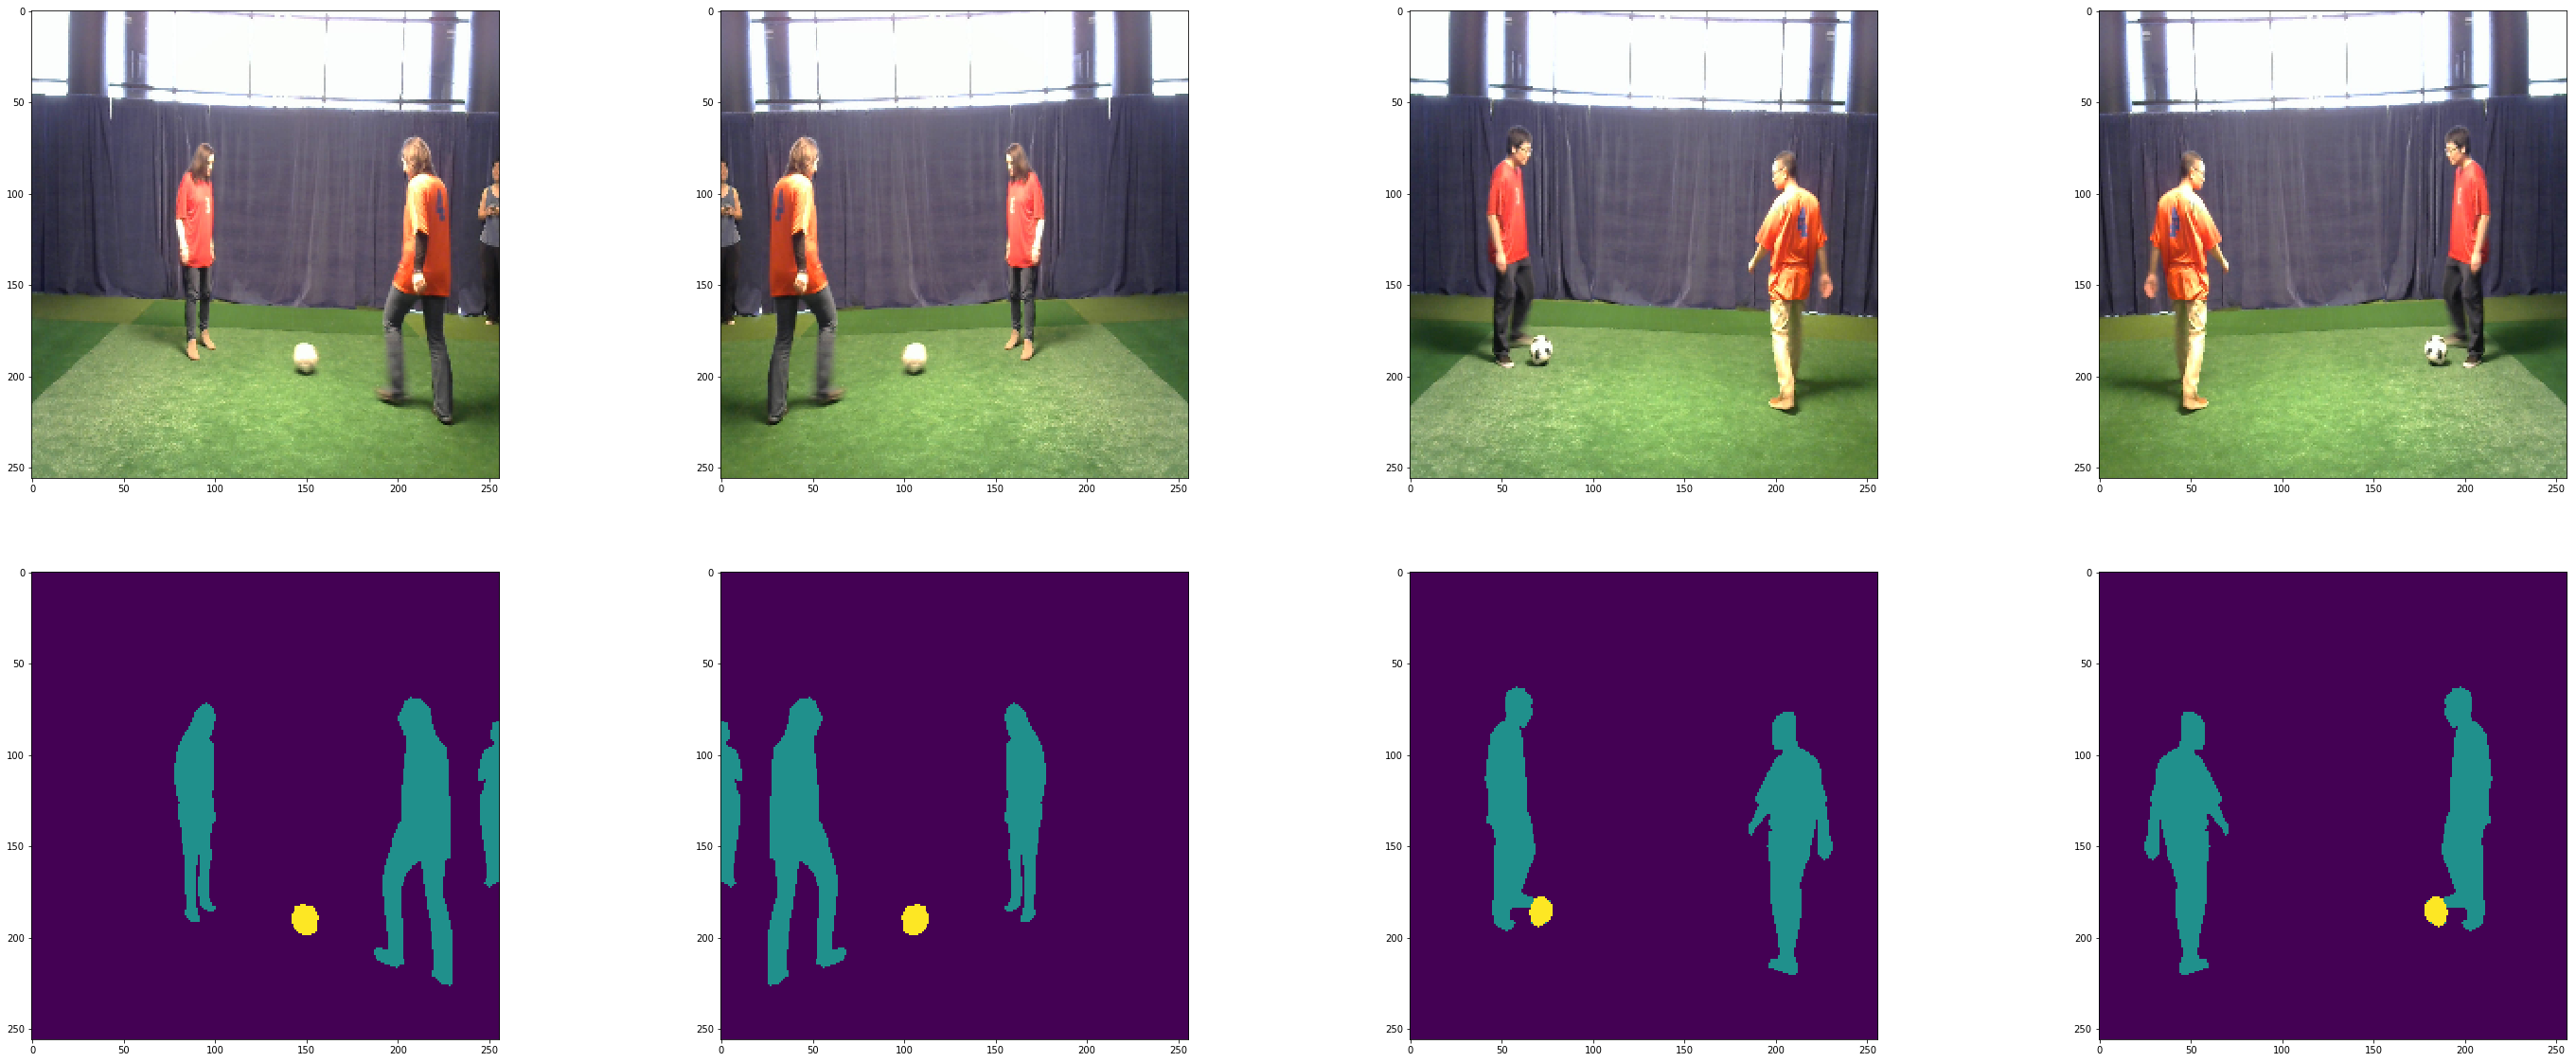

In [6]:
display_segmentation_images(s, 'data', n_images=4, segmentation_labels_table='data')

### 2.5 Randomly split data into training (70%), validation (20%) and testing (10%)

In [7]:
train = s.CASTable('data', where = 'idx >= 0.3')
len(train)

115

In [8]:
valid = s.CASTable('data', where = 'idx < 0.3 and idx >= 0.1')
len(valid)

33

In [9]:
test = s.CASTable('data', where = 'idx < 0.1')
len(test)

22

## 3 Build U-Net model
U-Net: Convolutional Networks for Biomedical Image Segmentation
https://arxiv.org/abs/1505.04597

In [10]:
model = UNet(s, 
             n_classes=3, 
             n_channels=3, 
             bn_after_convolutions=True)

NOTE: Model compiled successfully.


In [11]:
model.print_summary()

,Layer Id,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters
0,0,data,input,,,None,"(256, 256, 3)","(0, 0)"
1,1,Conv2d_1,convo,"(3, 3)","(1, 1)",Identity,"(256, 256, 64)","(1728, 0)"
2,2,BN_1,batchnorm,,,Relu,"(256, 256, 64)","(0, 128)"
3,3,Conv2d_2,convo,"(3, 3)","(1, 1)",Identity,"(256, 256, 64)","(36864, 0)"
4,4,BN_2,batchnorm,,,Relu,"(256, 256, 64)","(0, 128)"
5,5,Pooling_1,pool,"(2, 2)","(2, 2)",Max,"(128, 128, 64)","(0, 0)"
6,6,Conv2d_3,convo,"(3, 3)","(1, 1)",Identity,"(128, 128, 128)","(73728, 0)"
7,7,BN_3,batchnorm,,,Relu,"(128, 128, 128)","(0, 256)"
8,8,Conv2d_4,convo,"(3, 3)","(1, 1)",Identity,"(128, 128, 128)","(147456, 0)"
9,9,BN_4,batchnorm,,,Relu,"(128, 128, 128)","(0, 256)"


## Training
- miniBatchSize = 10 and nthreads = 1
- 60 epochs
- ADAM with starting learning rate = 2e-4

In [13]:
solver = AdamSolver(lr_scheduler=StepLR(learning_rate=0.0002, step_size=30, gamma=0.8), 
                    clip_grad_max = 100, 
                    clip_grad_min = -100)

optimizer = Optimizer(algorithm=solver, 
                      mini_batch_size=10, 
                      log_level=2, 
                      max_epochs=60, 
                      reg_l2=0.0005, 
                      seed=13309)

dataspecs=[dict(type='image', layer='data', data=['_image_']),
           dict(type='image', layer='Segmentation_1', data=['labels'])]

The following argument(s) learning_rate, learning_rate_policy, gamma, step_size, power are overwritten by the according arguments specified in lr_scheduler.


In [14]:
model.fit(data=train,
          valid_table=valid,
          optimizer=optimizer, 
          data_specs=dataspecs, 
          n_threads=1, 
          record_seed=54321,
          force_equal_padding=True, 
          gpu=1)

NOTE: Training from scratch.
NOTE: Using a.machine.with.2gpus: 2 out of 2 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 34520899.
NOTE:  The approximate memory cost is 4523.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost      11.25 (s).
NOTE:  The total number of threads on each worker is 1.
NOTE:  The total mini-batch size per thread on each worker is 10.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 10.
NOTE:  Number of input variables:     1
NOTE:  Number of numeric input variables:      1
NOTE:  Epoch Learning Rate        Loss  Fit Error  Validation Loss Validation Error   Time(s)
NOTE:  0        0.0002       5.036e+04     0.1432        7.009e+04           0.3858     9.32
NOTE:  1        0.0002       3.177e+04    0.02526        2.555e+04          0.03608     4.38
NOTE:  2        0.0002        2.05e+04    0.02317        1.712e+04          0.01732     4.38


,Descr,Value
0,Model Name,unet
1,Model Type,Convolutional Neural Network
2,Number of Layers,51
3,Number of Input Layers,1
4,Number of Output Layers,0
5,Number of Convolutional Layers,19
6,Number of Pooling Layers,4
7,Number of Fully Connected Layers,0
8,Number of Batch Normalization Layers,18
9,Number of Concatenation Layers,4


##  4 Scoring using testing data

In [15]:
model.predict(test, gpu=1)

NOTE: Due to data distribution, miniBatchSize has been limited to 2.
NOTE: Using a.machine.with.2gpus: 2 out of 2 available GPU devices.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read            22
 1  Number of Observations Used            22
 2  Misclassification Error (%)      0.559859
 3                   Loss Error      1559.796

[OutputCasTables]

             casLib              Name  Rows  Columns  \
 0  CASUSER(ethem-kinginthenorth)  Valid_Res_hk7eUR    22   131078   
 
                                             casTable  
 0  CASTable('Valid_Res_hk7eUR', caslib='CASUSER(e...  

+ Elapsed: 17.6s, user: 5.69s, sys: 2.74s, mem: 2.03e+04mb

In [16]:
def compile_segmentation_predictions():
    cvars = ['origimage', 'c0']
    for i in range(1, 256*256):
        list.append(cvars, 'c' + str(i))

    cvarspgm = "length origimage varchar(*); origimage=_image_; c0=input(_DL_PredName0_, 12.); "
    for i in range(1, 256*256):
        cvarspgm += 'c' + str(i) + '=input(_DL_PredName' + str(i) + '_, 12.); '

    r = s.table.view(
        name='oview',
        tables=[dict(name=model.valid_res_tbl.name,
                     computedvars=cvars, 
                     computedvarsprogram=cvarspgm,
                     varlist={'_DL_PredName0_', '_filename_0'})],
        replace=True)
    renamed=0
    s.image.condenseimages(table='oview',
                           width=256, height=256, 
                           casout=dict(name='final_images_predicted', replace=True),
                           numberofchannels=1,
                           depth='bit32',
                           copyvars=['origimage', '_filename_0'])

In [17]:
compile_segmentation_predictions()

NOTE: 22 out of 22 images were processed successfully and saved to the Cloud Analytic Services table final_images_predicted.


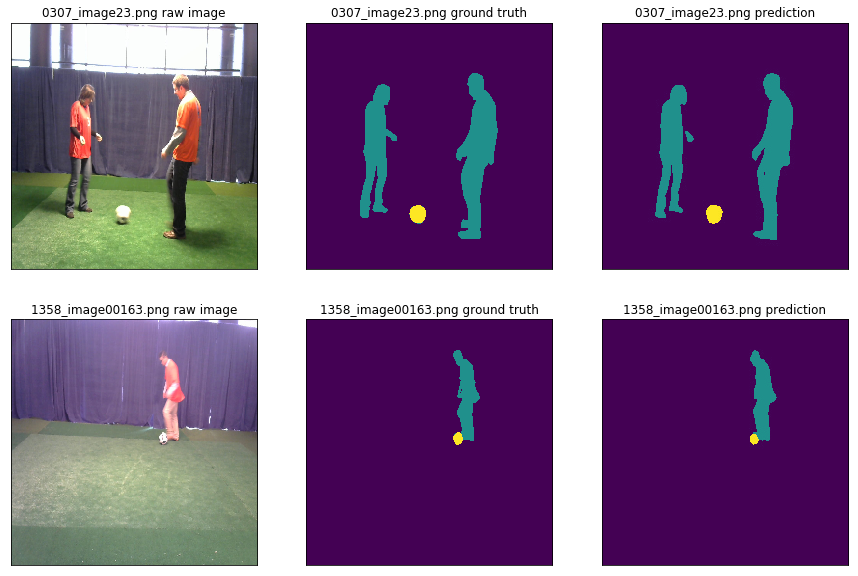

In [18]:
display_segmentation_results(s, 
                             model.valid_res_tbl, 
                             n_images=2, 
                             segmentation_labels_table=model.valid_res_tbl,
                             segmentation_prediction_table='final_images_predicted',
                             prediction_column='_image_',
                             filename_column='_filename_0',
                             fig_size=(15,10))

In [19]:
s.endsession()

+ Elapsed: 7.9e-05s, mem: 0.194mb